In [1]:
# instance CRN for the SQL Query instance - Look for the 'SQL Query app' under https://console.bluemix.net/dashboard/apps 
instnacecrn="crn:v1:bluemix:public:sql-query:us-south:a/01fedb4f3ff70b186d83cdb1e1df6879:3aa64b96-c4cc-4880-9ba0-efdd62bb838a::"
# API key for an IBM Cloud Object Storage bucket - under https://console.bluemix.net/iam/#/apikeys execute Manage->Security->Platform API Keys, click Create 
apikey="ZHdGyRMu9qTfy_dHeQNqnVxYmM_EtGwZtkGr2cE_sLtc"
# Query results destination - Follow the format as bellow
targeturl="cos://us-south/sql-3aa64b96-c4cc-4880-9ba0-efdd62bb838a/result/"    
# The SQL Query to perform - Follow the format as bellow (might change the */* to fit regex that match date/need/other)
sql = """
WITH flows as (SELECT explode(data) flow
                           FROM cos://us-south/sa-seclogs-eran/IBM/netflow/vpc-region/vpc-guid/0/ingress/*/* STORED AS JSON)
SELECT flow.UUID, 
flow.Status, 
flow.Version, 
flow.Start, 
flow.Last, 
flow.Network.A AS src_ip, 
flow.Transport.A AS src_port, 
flow.Network.B AS dst_ip, 
flow.Transport.B  AS dst_port, 
flow.Transport.Protocol, 
flow.Metric.ABPackets, 
flow.Metric.BAPackets, 
flow.Metric.ABBytes, 
flow.Metric.BABytes
FROM flows"""
# max number of IPs to show (Limit time/cpu)
maxips = 100

# Installing prerequsits:

In [3]:
!pip install tensorflow
!pip install numpy
!conda install pyarrow
!conda install sqlparse
!pip install ibmcloudsql
!pip install maxminddb-geolite2

     |████████████████████████████████| 3.2MB 1.2MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pyarrow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                1         134 KB

The following packages will be UPDATED:

    ca-certificates: 2019.5.15-0 --> 2019.5.15-1


ca-certificates-2019 | 134 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - sqlparse


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    sqlparse-0.3.0             |            

# Prepare and Execute SQL Query (flow logs from COS to memory)

In [4]:
import ibmcloudsql
import pandas as pd
import sqlparse
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import networkx as nx
import tensorflow as tf
import scipy
import matplotlib
import time
import seaborn as sn
from geolite2 import geolite2
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix

sqlClient = ibmcloudsql.SQLQuery(apikey, instnacecrn, client_info='SQL Query FlowLogs')
sqlClient.logon()
sql_with_target = sql + ' INTO {} STORED AS CSV'.format(targeturl)
print('SQL will execute the query :\n============================\n\n %s' % sql_with_target )

print ("Started executing, this might take a while, so wait for it ... :-) To follow progress use:")
sqlClient.sql_ui_link()
result_df = sqlClient.run_sql(sql_with_target)
print ("Completed.\n\n")

SQL will execute the query :

 
WITH flows as (SELECT explode(data) flow
                           FROM cos://us-south/sa-seclogs-eran/IBM/netflow/vpc-region/vpc-guid/0/ingress/*/* STORED AS JSON)
SELECT flow.UUID, 
flow.Status, 
flow.Version, 
flow.Start, 
flow.Last, 
flow.Network.A AS src_ip, 
flow.Transport.A AS src_port, 
flow.Network.B AS dst_ip, 
flow.Transport.B  AS dst_port, 
flow.Transport.Protocol, 
flow.Metric.ABPackets, 
flow.Metric.BAPackets, 
flow.Metric.ABBytes, 
flow.Metric.BABytes
FROM flows INTO cos://us-south/sql-3aa64b96-c4cc-4880-9ba0-efdd62bb838a/result/ STORED AS CSV
Started executing, this might take a while, so wait for it ... :-) To follow progress use:
https://sql.ng.bluemix.net/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/01fedb4f3ff70b186d83cdb1e1df6879:3aa64b96-c4cc-4880-9ba0-efdd62bb838a::
Completed.




In [5]:
from ibm_botocore.client import Config
import ibm_boto3

credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-5cead18f-7eb5-487d-93ad-d848f90a46e6',
    'IBM_API_KEY_ID': 'q2bzIZBPZ9Lkrz8uDBmr5l44Re56xWFkPlGLOcjuEzRF',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'flowlogsanalytics-donotdelete-pr-7vrxdvrveals1x',
    'FILE': 'ts.csv'
}

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

cos.download_file(Bucket=credentials['BUCKET'],Key='ts.csv',Filename='ts.csv')

ext_data = pd.read_csv('ts.csv')
ext_data = ext_data.rename(columns={"met_val": "Ext_data"})

# Utility Functions

In [6]:
def get_country(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

# Human-readable format
def number_format(num):
    magnitude = 0
    while num >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Scales arrays s.t the highest element size will be exactly max_size, and the ratio between every two element sizes will be 100 at most 
def scale(arr, max_size):
    while np.max(arr) > 100 * np.min(arr):
        arr = np.sqrt(arr)
    arr = arr * max_size / np.max(arr)
    return arr

# Returns the rows whereby the "Start" value is between the given dates
def date_filter(df, year1, month1, day1, year2, month2, day2):
    start_date = pd.to_datetime('%s-%s-%s' % (year1, month1, day1))
    end_date = pd.to_datetime('%s-%s-%s' % (year2, month2, day2))
    mask = (df['Start'] >= start_date) & (df['Start'] <= end_date)
    return df.loc[mask]

# Finds an index whereby the ratio between the sums of the sub-arrays it creates is maximized (returns the ratio and the index)
def calc_trend(df):
    high, index = 0, 0
    for i in range(1, len(df.index) - 1):
        before, after = np.mean(df.values[:i]), np.mean(df.values[i:])
        tmp = 100*(before-after)/before if before > 0 else 0
        if tmp > high:
            high, index = tmp, i
    return (high, df.index[index]) 

## Returns a dataset by demand (pandas df)
def get_data(kind):
    tot_df = flowlogs_df.set_index('Start')[['Total_Packets', 'Total_Bytes']].resample('1H').sum().fillna(0)  

    samples_num = len(tot_df.index)
    sin_arr1 = [np.sin(2*np.pi*x/24) * 0.1 * np.max(tot_df["Total_Packets"]) for x in range(samples_num)]
    sin_arr2 = [np.sin(2*np.pi*x/4) * 0.01 * np.max(tot_df["Total_Packets"]) for x in range(samples_num)]
    tot_df["Noisy_Packets"] = tot_df["Total_Packets"] + sin_arr1 + sin_arr2
    
    tot_df["flows"] = flowlogs_df.set_index('Start').resample('1H').size().replace(0, np.nan)
    tot_df["averageFlowPacket"] = tot_df["Total_Packets"] / tot_df["flows"]
    tot_df["averageFlowByte"] = tot_df["Total_Bytes"] / tot_df["flows"]
    tot_df["averagePacketSize"] = tot_df["Total_Bytes"] / tot_df["flows"]
    tot_df["flowBehavior"] = tot_df["flows"] / tot_df["averagePacketSize"]
    tot_df = tot_df.fillna(0)

    if kind == "Total_Packets":
        return tot_df.loc[:, ["Total_Packets"]]
    if kind == "Noisy_Packets":
        return tot_df.loc[:, ["Noisy_Packets"]] 
    if kind == "Att":
        return tot_df[["flows", "averageFlowPacket", "averageFlowByte", "averagePacketSize", "flowBehavior"]]
    if kind == "Ext_data":
        return ext_data.loc[:, ["Ext_data"]]

## Smooth a DF
def smooth_moving_average(data, window, stride=1):
    samples_num = int((len(data)  - window) / stride)
    indices = [i*stride + int(0.5*window) for i in range(samples_num)]
    return indices, [np.mean(data[i-int(0.5*window):i+int(0.5*window)]) for i in indices]

## Smooth a DF
def smooth_LP(df, coeff=4, thresh=0.1, stride=1):
    samples_num = int(len(df.index) / stride)
    indices = [df.index[i*stride] for i in range(samples_num)]
    smoothed_df = pd.DataFrame(index=indices, columns=df.columns)
    sample_indices = [i*stride for i in range(samples_num)]
    b, a = signal.butter(coeff, thresh)
    for c in df.columns:
        filtered = signal.lfilter(b, a, df[c].values)
        smoothed_df[c] = [filtered[i] for i in sample_indices]
    return smoothed_df

def conv2d(x, W, stride=1):
  return tf.nn.conv2d(x, W, strides=[1, 1, stride, 1], padding='SAME')

# min-max normalization
def normalize(data):
    for c in data.columns:
        if(data[c].dtype == np.float64 or data[c].dtype == np.int64):
            data[c] = ((data[c] - np.min(data[c])) / (np.max(data[c]) - np.min(data[c]))).fillna(0)
    return data

# Given an array, finds indexes of extremely-high values
def find_anomalies(scores, thresh=1):
    threshold = np.mean(scores) + thresh * np.std(scores)
    return [i for (i, x) in enumerate(scores) if x > threshold]

def anomaly_visualization(x, y, anomaly_indices):
    plt.figure(figsize=(20,5))
    plt.plot(x, y, 'b', linewidth=2)
    for i in anomaly_indices:
        plt.plot(x[i-1:i+1], y[i-1:i+1], 'r', linewidth=3)

    plt.xlabel('Time', fontsize=20), plt.ylabel('Packets', fontsize=20)
    plt.title("Signal Anomalies", fontsize=25)
    plt.show()
    
def trend_visualization(x, y, anomaly_indices):
    plt.figure(figsize=(20,5))
    anomaly_indices = anomaly_indices + [0, len(x)-1]
    anomaly_indices.sort()
    
    for i in range(1, len(anomaly_indices)):
        start, end = anomaly_indices[i-1], anomaly_indices[i]
        mid = int(0.5 * (start + end - 1))
        plt.plot(x[start:end], y[start:end])
        plt.annotate("Avg: %.2f" % np.mean(y[start:end]), xy=(x[mid], 0.1*np.max(y) + y[mid]), ha='center', bbox=dict(boxstyle="round4", fc="1."))
        if i < len(anomaly_indices) - 1:
            plt.plot(x[end-1:end+1], y[end-1:end+1], 'r', dashes=[3, 3])

    plt.xlabel('Time', fontsize=20), plt.ylabel('Packets', fontsize=20)
    plt.title("Signal Trends", fontsize=25)
    plt.ylim(0, 1.5 * np.max(y))
    plt.show()
    
def find_changepoints(data, segsize, thresh):
    indices, cur_seg = [], []
    length = len(data)
    for i in range(length):
        cur_seg.append(data[i])
        x = np.array(range(len(cur_seg))).reshape((-1, 1))
        model = LinearRegression().fit(x, cur_seg)
        pred = model.predict(x)
        if mean_squared_error(pred, cur_seg) > thresh:
            indices.append(i)
            cur_seg = []
        elif len(cur_seg) > segsize:
            cur_seg.pop(0)
    return indices

def time_series(data, window):
    df_data, df_labels = pd.DataFrame(index=data.index[window:], columns=range(len(data.columns)*window)), pd.DataFrame(index=data.index[window:], columns=range(len(data.columns)))
    values = data.values.tolist()
    for i in range(len(df_data.index)):
        arr = []
        for k in range(window):
            arr = arr + values[i+k] 
        df_data.iloc[i] = arr
        df_labels.iloc[i] = data.iloc[window+i].values
    return df_data, df_labels

def get_stft(data, index, nperseg=100, noverlap=99):
    f, ts, Zxx = signal.stft(data, nperseg=nperseg, noverlap=noverlap)
    df = pd.DataFrame(index=[index[int(t)] for t in ts[:-(nperseg+1)]], columns=range(Zxx.shape[0]))
    for ind in range(len(df.index)):
        df.iloc[ind] = [np.abs(Zxx[i, ind]) for i in range(Zxx.shape[0])]
    plt.figure(figsize=(20, 4))
    plt.pcolormesh(ts, f, np.abs(Zxx))
    plt.title("Signal Spectrogram", fontsize=25)
    plt.xlabel('Time', fontsize=20), plt.ylabel('Frequency', fontsize=20)
    plt.show()
    return df

def plot_confusion_matrix(a, b):
    cm = confusion_matrix(a, b)
    plt.figure(figsize = (7,7))
    sn.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted'), plt.ylabel('Actual')
    plt.show()

# Organize The Raw Data

In [7]:
flowlogs_df = result_df.astype({'Start': 'datetime64[ms]','Last': 'datetime64[ms]',})
flowlogs_df = flowlogs_df.drop_duplicates()

# Artificially add an Action field, which gets an ACCEPTED value when dst_port=22. To be removed in the future
flowlogs_df['Action'] = np.where(flowlogs_df['dst_port']!=22.0, 'ACCEPTED', 'REJECTED')
flowlogs_df['Total_Packets'] = flowlogs_df['ABPackets'] + flowlogs_df['BAPackets']
flowlogs_df['Total_Bytes'] = flowlogs_df['ABBytes'] + flowlogs_df['BABytes']

flowlogs_df.head(10)

,UUID,Status,Version,Start,Last,src_ip,src_port,dst_ip,dst_port,Protocol,ABPackets,BAPackets,ABBytes,BABytes,Action,Total_Packets,Total_Bytes
0,c9dc2a0af402653f,ENDED,1.0.8,2019-05-22 19:45:17.261,2019-05-22 19:45:36.375,58.242.82.4,26988.0,169.60.53.46,22.0,TCP,26,54,3386,9642,REJECTED,80,13028
1,58f2a43758662b06,UPDATED,1.0.8,2019-05-22 16:31:47.306,2019-05-22 19:45:45.312,195.110.40.7,59441.0,169.60.53.46,8082.0,TCP,5837,23304,350250,1285358,ACCEPTED,29141,1635608
2,9d70e98687814dad,ENDED,1.0.8,2019-05-22 19:44:36.733,2019-05-22 19:44:57.773,58.242.82.4,44825.0,169.60.53.46,22.0,TCP,29,58,4248,9954,REJECTED,87,14202
3,237b48c0d5705413,ENDED,1.0.8,2019-05-22 19:44:58.269,2019-05-22 19:45:16.758,58.242.82.4,5165.0,169.60.53.46,22.0,TCP,26,54,3386,9642,REJECTED,80,13028
4,3e10bea1304814f1,UPDATED,1.0.8,2019-05-22 16:32:28.931,2019-05-22 19:45:46.138,195.110.40.7,4492.0,169.60.53.46,22.0,TCP,4384,21500,274038,4376520,REJECTED,25884,4650558
5,9ca692356733a1cd,UPDATED,1.0.8,2019-05-22 16:31:47.225,2019-05-22 19:45:47.003,195.110.40.7,57300.0,169.60.53.46,22.0,TCP,23251,46502,1813674,2511252,REJECTED,69753,4324926
6,707cb55d3e1f9216,UPDATED,1.0.8,2019-05-22 16:32:06.894,2019-05-22 19:45:14.517,195.110.40.7,55912.0,169.60.53.46,22.0,TCP,232,468,22954,36848,REJECTED,700,59802
7,2785b1bd94e95943,UPDATED,1.0.8,2019-05-22 16:31:47.241,2019-05-22 19:45:22.245,169.46.118.97,443.0,169.60.53.46,57950.0,TCP,6035,7215,1218228,13808590,ACCEPTED,13250,15026818
8,3a8a331c00f1a392,UPDATED,1.0.8,2019-05-22 16:35:21.238,2019-05-22 19:45:24.638,195.110.40.7,59937.0,169.60.53.46,22.0,TCP,395,812,38342,103718,REJECTED,1207,142060
9,b560bd555502f4d7,UPDATED,1.0.8,2019-05-22 16:31:52.611,2019-05-22 19:45:46.254,195.110.40.7,25222.0,169.60.53.46,8082.0,TCP,9254,9269,2958258,2857376,ACCEPTED,18523,5815634


# Daily Traffic

In [ ]:
data_df = date_filter(flowlogs_df, 2019, 4, 23, 2019, 4, 30)
tot_df = data_df.set_index('Start')[['Total_Packets', 'Total_Bytes']].resample('1D').sum().fillna(0)
tot_df.plot.bar(tot_df.index.date, rot=0, log=True, figsize=(20, 5))
plt.show()

# One-Way Flows

In [ ]:
indices = flowlogs_df.set_index('Start').resample('1D').count().index
twowaytcp = flowlogs_df[(flowlogs_df['ABPackets'] != 0) & (flowlogs_df['BAPackets'] != 0) & (flowlogs_df['Protocol'] == "TCP")].set_index('Start').iloc[:, 0].resample('1D').count().values
onewaytcp = flowlogs_df[((flowlogs_df['ABPackets'] == 0) | (flowlogs_df['BAPackets'] == 0)) & (flowlogs_df['Protocol'] == "TCP")].set_index('Start').iloc[:, 0].resample('1D').count().values
tcp_df = pd.DataFrame(index=indices, columns=["Two_Way_TCP", "One_Way_TCP"])
tcp_df["Two_Way_TCP"] = twowaytcp
tcp_df["One_Way_TCP"] = onewaytcp
tcp_df.plot.bar(tcp_df.index.date, stacked=True, figsize=(20, 5))
plt.show()

# Hotspots

In [ ]:
# Select number of hotspots to detect
hotspots_num = 3
src_df = flowlogs_df.groupby(['src_ip']).agg({'Total_Packets':'sum'})
dst_df = flowlogs_df.groupby(['dst_ip']).agg({'Total_Packets':'sum'})
tot_df = src_df.append(dst_df)
tot_df = tot_df.groupby(tot_df.index).agg({'Total_Packets':'sum'}).sort_values(by=['Total_Packets'], ascending=False).head(hotspots_num)

print("The most active instance is %s, which sends and receives an averaged amount of %s packets per day" % (tot_df.index[0], number_format(tot_df["Total_Packets"].values[0] / len(flowlogs_df.index))))

plt.figure(figsize=(20, 4))

for instance in tot_df.index:
    instance_df = flowlogs_df[(flowlogs_df['src_ip'] == instance) | (flowlogs_df['dst_ip'] == instance)].set_index('Start')["Total_Packets"].resample('1H').sum().fillna(0).to_frame("Total_Packets")["Total_Packets"].plot()
plt.legend()
plt.show()

# Rejection Percentage by Source

In [ ]:
## Insert an IP address 
ip = "195.110.40.7"
src_df = flowlogs_df.loc[flowlogs_df['src_ip'] == ip]
rejection_ratio = 100 * len(src_df.loc[src_df['Action'] == "REJECTED"].index) / len(src_df.index)
rejection_str = str(int(rejection_ratio)) + "%" 

pts1 = [(-1, 0), (1, 0), (0, 100)]
pts2 = [(-1, 0), (-1+rejection_ratio*0.01, rejection_ratio), (1-rejection_ratio*0.01, rejection_ratio), (1, 0)]
plt.figure(figsize=(2,4))
ax = plt.subplot(111)
triangle = plt.Polygon(pts1, fill=False, edgecolor='black')
percentage = plt.Polygon(pts2, fill=True, edgecolor='orange', facecolor='orange')
ax.add_patch(percentage)
ax.add_patch(triangle)

ax.plot()
ax.axis('off')
plt.title("Rejection Percentage of %s" % ip, y=1.02, fontdict={'fontsize': 15})
plt.annotate(rejection_str, xy=(0,rejection_ratio+1), ha="center", size=14)

plt.show()

## Rejection Percentage Histogram

In [ ]:
tot_df = flowlogs_df.groupby(['src_ip']).size().to_frame('size')
rejected_df = flowlogs_df.loc[flowlogs_df['Action']=='REJECTED'].groupby(['src_ip']).size().to_frame('size')
tot_df["Ratio"] = (rejected_df["size"] / tot_df["size"]).fillna(0)*100
plt.figure(figsize=(15,4))
plt.hist(tot_df["Ratio"], log=True)
plt.xticks(range(0, 101, 10))
plt.show()

# Total Traffic - Port Distribution

In [ ]:
portsAB_df = flowlogs_df.groupby(['dst_port']).agg({'ABPackets':'sum'}).nlargest(10, 'ABPackets')
portsBA_df = flowlogs_df.groupby(['src_port']).agg({'BAPackets':'sum'}).nlargest(10, 'BAPackets').rename(columns={"BAPackets": "ABPackets"})
ports_df = portsAB_df.append(portsBA_df)
res_df = ports_df.groupby(ports_df.index).agg({'ABPackets':'sum'}).nlargest(10, 'ABPackets')
res_df.plot(kind='pie', figsize=(10,10), subplots='True')
plt.show()

# Top Source-Destination Locations of Traffic, by Flows

In [ ]:
print("This might take a while, please wait...")
geo = geolite2.reader()
flowlogs_df['src_country'] = flowlogs_df['src_ip'].apply(get_country)
flowlogs_df['dst_country'] = flowlogs_df['dst_ip'].apply(get_country)
geolite2.close()
flowlogs_df.groupby(['src_country', 'dst_country']).size().to_frame('flows_num').nlargest(10, 'flows_num').reset_index()

# Inbound/Outbound Packets by Source

In [ ]:
## Insert an IP address 
ip = "5.102.239.42"
src_df = flowlogs_df.loc[flowlogs_df['src_ip'] == ip]
dst_df = flowlogs_df.loc[flowlogs_df['dst_ip'] == ip]

inbound = np.nan_to_num(src_df["BAPackets"].sum()) + np.nan_to_num(dst_df["ABPackets"].sum())
outbound = np.nan_to_num(src_df["ABPackets"].sum()) + np.nan_to_num(dst_df["BAPackets"].sum())

plt.figure(figsize=(2,5))
plt.xticks([1, 2], ["inbound", "outbound"]), plt.yticks([inbound, outbound])
plt.bar([1], [inbound], color='green'), plt.bar([2], [outbound], color='orange')
plt.title("Amount of Packets", y=1.1, fontdict={'fontsize': 15})
plt.show()

# Average Packet Size

In [ ]:
inverted_df = flowlogs_df.rename(columns={"BAPackets":"ABPackets", "ABPackets":"BAPackets", "BABytes":"ABBytes", "ABBytes":"BABytes"}).append(flowlogs_df).groupby(['src_ip']).agg({'ABPackets':'sum', 'ABBytes':'sum'})
inverted_df["avg_size"] = inverted_df["ABBytes"] / inverted_df["ABPackets"]
plt.figure(figsize=(15,6))
bins = [100 * i for i in range(int(2 + 0.01*np.max(inverted_df["avg_size"].values)))]
plt.hist(inverted_df["avg_size"], log=True, bins=bins)
plt.xticks([bin for bin in bins])
plt.title("Average Packet Size", size=25)
plt.xlabel('Average Packet Size', size=15), plt.ylabel('Amount of Instances (Log Scale)', size=15)
plt.show()

# Top-N Talking Pairs, by Chosen Metric

In [ ]:
# Insert amout of pairs
N = 10
AB_df = flowlogs_df.loc[flowlogs_df["src_ip"] > flowlogs_df["dst_ip"]]
BA_df = flowlogs_df.loc[flowlogs_df["dst_ip"] > flowlogs_df["src_ip"]].rename(columns={"src_ip":"dst_ip", "dst_ip":"src_ip", "ABPackets":"BAPackets", "BAPackets":"ABPackets"})
ordered_df = AB_df.append(BA_df)
    
res_df = ordered_df.groupby(['src_ip', 'dst_ip']).agg({"Total_Packets":'sum', "ABPackets":'sum', "BAPackets":'sum'}).nlargest(N, 'Total_Packets').sort_values(by=["Total_Packets"], ascending=False).reset_index()

ip1, ip2, stream1, stream2 = res_df.iloc[0][["src_ip", "dst_ip", "ABPackets", "BAPackets"]]
A, B, AB, BA = (ip1, ip2, stream1, stream2) if stream1 > stream2 else (ip2, ip1, stream2, stream1)

print("The top talking pair is (%s, %s)," % (A,  B))
print("While %.2f%% of the traffic goes from %s to %s\n\n\n" % (100*AB/(AB + BA), A,  B))

# Plot Graph

plt.figure(figsize=(20,10))

edges = [(res_df['src_ip'].iloc[i], res_df['dst_ip'].iloc[i], {'weight': res_df['Total_Packets'].iloc[i]}) for i in range(len(res_df.index))]

G = nx.OrderedGraph()
G.add_edges_from(edges)

# positions for all nodes
pos = nx.circular_layout(G) 

# labels
nx.draw_networkx_labels(G, pos)

# edge widths
widths = scale(res_df['Total_Packets'].values, 10)

# edges
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.3)

# node sizes
sizes = scale([elem[1] for elem in G.degree(weight='weight')], 2000)

nx.draw_networkx_nodes(G, pos, node_color = 'orange', node_size = sizes)

# weights
labels = nx.get_edge_attributes(G, 'weight')
for key, value in labels.items():
    labels[key] = number_format(value)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.axis('off')
plt.title('Top-%s Talking Pairs' % N, fontsize=30)
plt.show()

# Alerts

In [ ]:
# Select threshold of flows and duration (by hours)
threshold = 13000
duration = 1
sorted_df = flowlogs_df.sort_values(by=['dst_ip', 'Start'])
shifted_df = sorted_df.shift(-threshold)
sorted_df['Diff'] = (shifted_df['Start'] - sorted_df['Start']).astype('timedelta64[h]')
alerts_df = sorted_df.loc[(sorted_df['Diff'] < duration) & (shifted_df['dst_ip'] == sorted_df["dst_ip"])]
alerts_df[['Start', 'dst_ip']].reset_index(drop=True).head(10)

## Most Significant Trend of a Hotspot

In [ ]:
hotspots_num = 5
src_df = flowlogs_df.groupby(['src_ip']).agg({'Total_Packets':'sum'})
dst_df = flowlogs_df.groupby(['dst_ip']).agg({'Total_Packets':'sum'})
tot_df = src_df.append(dst_df)
tot_df = tot_df.groupby(tot_df.index).agg({'Total_Packets':'sum'}).sort_values(by=['Total_Packets'], ascending=False).head(hotspots_num)

high, date, ip = 0, 0, 0
for instance in tot_df.index:
    instance_score, i = calc_trend(flowlogs_df[(flowlogs_df['src_ip'] == instance) | (flowlogs_df['dst_ip'] == instance)].set_index('Start')["Total_Packets"].resample('1D').sum().fillna(0))
    if instance_score > high:
        ip, high, date = instance, instance_score, i
 
print("IP %s has lowered his activity by %.2f%% since %s" % (ip, high, date.strftime('%Y-%m-%d')))

# Anomaly Detection

## Autoencoder

In [ ]:
data_name = "Att"
data_df = normalize(get_data(data_name))

train_size, test_size = int(0.8 * len(data_df.index)), int(0.2 * len(data_df.index))
train_set, test_set = data_df.iloc[test_size:], data_df.iloc[:test_size]
epoch_num = 50
encoded_window = 4

x = tf.placeholder(tf.float32, len(data_df.columns))
x_reshaped = tf.reshape(x, [1, len(data_df.columns)])

W1, W2 = weight_variable([len(data_df.columns), encoded_window]), weight_variable([encoded_window, len(data_df.columns)])
b1, b2 = bias_variable([encoded_window]), bias_variable([len(data_df.columns)]) 

x1 = tf.nn.relu(tf.matmul(x_reshaped, W1) + b1)
x2 = tf.matmul(x1, W2) + b2

loss = tf.reduce_mean(tf.square(x2 - x_reshaped))
train = tf.train.RMSPropOptimizer(0.01).minimize(loss, var_list=[W1, W2, b1, b2])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epoch_num):
        for i in range(train_size):
            sess.run(train, feed_dict={x: train_set.iloc[i]})
        if epoch % 10 == 0:
            scores = [loss.eval(feed_dict={x: test_set.iloc[i]}) for i in range(test_size)]
            print('epoch %s, loss: %f' % (epoch, np.mean(scores)))
    print("DONE")

    scores = [loss.eval(feed_dict={x: test_set.iloc[i]}) for i in range(test_size)]
    packets = get_data("Total_Packets")
    xaxis = packets.index[0:test_size].to_pydatetime() if data_name!="Ext_data" else packets.index[0:test_size]
    anomaly_visualization(xaxis, packets.values[0:test_size], find_anomalies(scores, 0.25))

## Preapare Time-Series Data

In [8]:
data_name = "Ext_data"
# "data_df" consists of one column, which is the original signal we try to predict
data_df = normalize(get_data(data_name)).iloc[8000:10005]
# every row in "data" consists of N subsequent rows from "data_df"
data, labels = time_series(data_df, window=20)

train_size = int(0.8*len(data.index)) 
test_size = len(data.index)-train_size
train_set, test_set, train_labels, test_labels = data[:train_size], data[train_size:], labels[:train_size], labels[train_size:]
sample_len, label_len = len(data.columns), len(labels.columns)

## Prediction With Simple ANN

In [10]:
epoch_num = 1
encoded_window = 50

initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, sample_len)
y = tf.placeholder(tf.float32, label_len)
x_reshaped = tf.reshape(x, [1, sample_len])
W1, W2 = tf.Variable(initializer([sample_len, encoded_window])), tf.Variable(initializer([encoded_window, label_len]))
b1, b2 = tf.Variable(initializer([encoded_window])), tf.Variable(initializer([label_len])) 

x1 = tf.nn.relu(tf.matmul(x_reshaped, W1) + b1)
x2 = tf.matmul(x1, W2) + b2
loss = tf.reduce_mean(tf.square(x2 - y))
train = tf.train.RMSPropOptimizer(0.001).minimize(loss, var_list=[W1, W2, b1, b2])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    start = time.perf_counter()
    for epoch in range(epoch_num):
        if epoch % 3 == 0:
            scores_train = [loss.eval(feed_dict={x: train_set.iloc[i], y: train_labels.iloc[i]}) for i in range(train_size)]
            scores_test = [loss.eval(feed_dict={x: test_set.iloc[i], y: test_labels.iloc[i]}) for i in range(test_size)]
            print('epoch %s, train loss: %f, test loss: %f' % (epoch, np.mean(scores_train), np.mean(scores_test)))
        for i in range(train_size):
            sess.run(train, feed_dict={x: train_set.iloc[i], y: train_labels.iloc[i]})
    elapsed = time.perf_counter() - start
    print('Train Time: %.1f Seconds' % elapsed)
    start = time.perf_counter()
    scores = [loss.eval(feed_dict={x: test_set.iloc[i], y: test_labels.iloc[i]}) for i in range(test_size)]
    elapsed = time.perf_counter() - start
    print('Inference Time: %.1f Seconds' % elapsed)

epoch 0, train loss: 0.252383, test loss: 0.260680
Train Time: 11.8 Seconds
Inference Time: 0.8 Seconds


## Prediction With CNN

In [ ]:
epoch_num = 10
initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, sample_len)
y = tf.placeholder(tf.float32, label_len)
x_reshaped = tf.reshape(x, [1, 1, sample_len, 1])
W1, W2, W3 = tf.Variable(initializer([1, 5, 1, 1])), tf.Variable(initializer([1, 3, 1, 1])), tf.Variable(initializer([int(sample_len*0.25), label_len]))
b1, b2, b3 =  tf.Variable(initializer([1])),  tf.Variable(initializer([1])),  tf.Variable(initializer([label_len])) 

x1 = tf.nn.relu(conv2d(x_reshaped, W1, stride = 2) + b1)
x2 = tf.nn.relu(conv2d(x1, W2, stride = 2) + b2)
x2 = tf.reshape(x2, [1, int(sample_len*0.25)])
x3 = tf.matmul(x2, W3) + b3
loss = tf.reduce_mean(tf.square(x3 - y))
train = tf.train.RMSPropOptimizer(0.001).minimize(loss, var_list=[W1, W2, W3, b1, b2, b3])

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    start = time.perf_counter()
    for epoch in range(epoch_num):
        if epoch % 3 == 0:
            scores_train = [loss.eval(feed_dict={x: train_set.iloc[i], y: train_labels.iloc[i]}) for i in range(train_size)]
            scores_test = [loss.eval(feed_dict={x: test_set.iloc[i], y: test_labels.iloc[i]}) for i in range(test_size)]
            print('epoch %s, train loss: %f, test loss: %f' % (epoch, np.mean(scores_train), np.mean(scores_test)))
        for i in range(train_size):
            sess.run(train, feed_dict={x: train_set.iloc[i], y: train_labels.iloc[i]})
    elapsed = time.perf_counter() - start
    print('Train Time: %.1f Seconds' % elapsed)
    start = time.perf_counter()
    scores = [loss.eval(feed_dict={x: test_set.iloc[i], y: test_labels.iloc[i]}) for i in range(test_size)]
    elapsed = time.perf_counter() - start
    print('Inference Time: %.1f Seconds' % elapsed)

## 1d Time-Series Anomaly Visualization

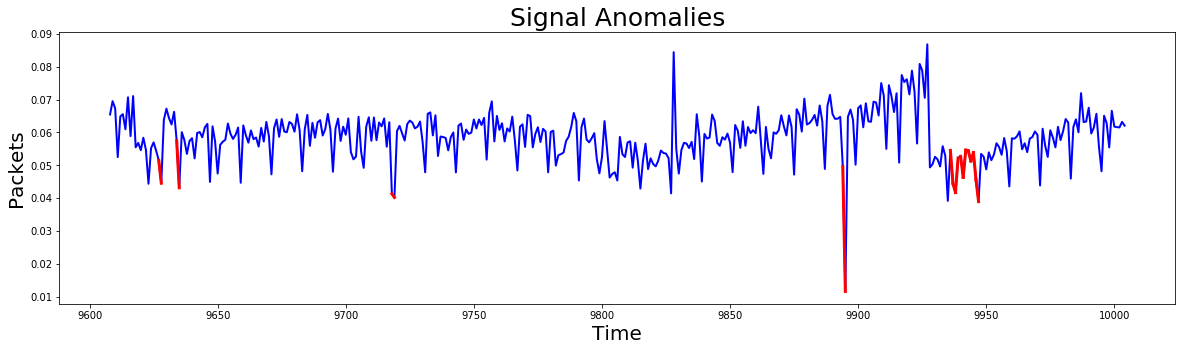

In [11]:
xaxis = test_set.index.to_pydatetime() if data_name!="Ext_data" else test_set.index.values
yaxis = [data_df.loc[x] for x in xaxis]
anomalies = find_anomalies(scores, 2)
anomaly_visualization(xaxis, yaxis, anomalies)

## Confusion Matrix

In [ ]:
my, their = [0] * test_size, [0] * test_size

anomalies_x = [xaxis[i] for i in anomalies]
for i in anomalies_x:
    my[i-xaxis[0]] = 1
    
anom_df = ext_data.iloc[test_set.index.values]
anom_df = anom_df[anom_df["is_anom"] == True]
for i in anom_df.index.values:
    their[i-xaxis[0]] = 1

plot_confusion_matrix(their, my)

## PCA

In [ ]:
data_name = "Att"
data = normalize(get_data(data_name))

train_size, test_size = int(0.8 * len(data)), int(0.2 * len(data))
train_set, test_set = data.iloc[test_size:].values, data.iloc[:test_size].values

pca = sklearn.decomposition.PCA()
pca.fit(train_set)

nComp = 4
Xhat = np.dot(pca.transform(test_set)[:,:nComp], pca.components_[:nComp,:]) + np.mean(test_set, axis=0)

scores = [np.square(test_set[i] - Xhat[i,]) for i in range(test_size)]
print('loss: %.3f' % np.mean(scores))

# Towards Trend Analysis

## Change Points

In [ ]:
window, stride = 1000, 250
thresh, segsize = 0.0002, 30

data_name = "Ext_data"
data_df = normalize(get_data(data_name))

x_indices, y = smooth_moving_average(data_df[data_name].values, window = window, stride = stride)
x = data_df.index[x_indices].to_pydatetime() if data_name!="Ext_data" else np.asarray(data_df.index[x_indices])
trend_visualization(x, y, find_changepoints(y, thresh=thresh, segsize=segsize))

## Seasonality with Autocorrelation

In [ ]:
window, stride = 5, 3

data_name = "Ext_data"
data_df = normalize(get_data(data_name))
x, data = smooth_LP(data_df[data_name].values[0:2500], stride = stride, thresh = 0.1)

plt.figure(figsize=(20,4))
plt.acorr(data, maxlags=10)
plt.title("Seasonality with Autocorrelation")
plt.xlabel("Lag"), plt.ylabel("Correlation")
plt.show()

## Seasonality with FFT

In [ ]:
window, stride = 5, 3

data_name = "Ext_data"
data_df = normalize(get_data(data_name))
x, data = smooth_LP(data_df[data_name].values[0:2500], stride = stride, thresh = 0.5)

length = len(data)
m = np.mean(data)
data = [x - m for x in data]
freq = np.linspace(0, 0.5, int(length/2))
energy = np.abs(scipy.fftpack.fft(data))[0:int(length/2)]
plt.figure(figsize=(20,4))
plt.plot(freq, energy)
plt.title("Seasonality with FFT")
plt.xlabel("Frequency"), plt.ylabel("Energy")
plt.show()

dom_freq = freq[find_anomalies(energy, 3)]
cycles = list(set(["%.1f" % (1 / f) for f in dom_freq if f > 0.01]))
print("This signal has periodicity of %s samples" % cycles)